## Scratch

In [1]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from tf_lab.fundamentals.utils import set_visible_GPUs, reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec


from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id, match_incomplete_to_complete_data
from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch, \
                                           plot_interpolations

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs
                                                  


from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud, Mesh
import geo_tool.solids.mesh_cleaning as cleaner

/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/point_clouds/point_cloud.py:19: UserWarning: Sklearn library is not installed.
  warnings.warn('Sklearn library is not installed.')
/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')
/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/tf_lab/autopredictors/evaluate.py:9: UserWarning: Sklearn library is not installed.
  warnings.warn('Sklearn library is not installed.')


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

In [12]:
syn_id = '03001627'
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
full_pclouds_path = osp.join(top_data_dir, 'ShapeNetPointClouds/from_manifold_meshes/4096/' + syn_id)
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path)
full_pclouds, full_model_names, full_syn_ids = pio.load_crude_point_clouds(file_names=full_file_names, n_threads=30)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )

6778 files containing complete point clouds were found.


In [27]:
mesh_top_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/ShapeNetManifold/20000/02933112/'
mesh_files = [f for f in files_in_subdirs(mesh_top_dir, 'model.obj')]

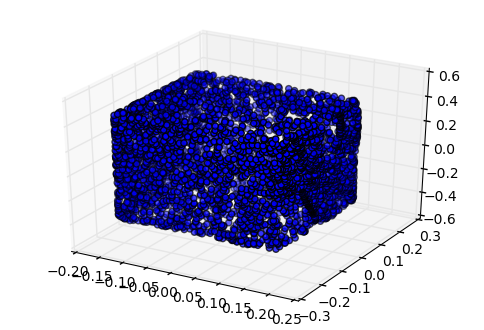

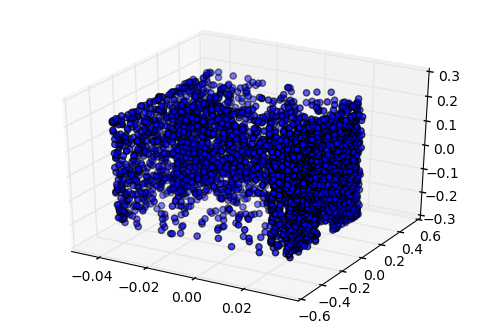

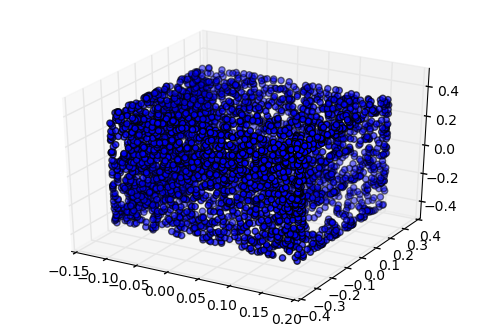

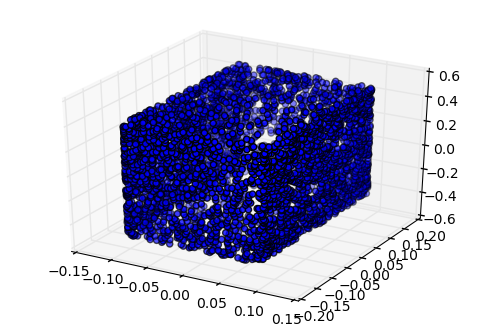

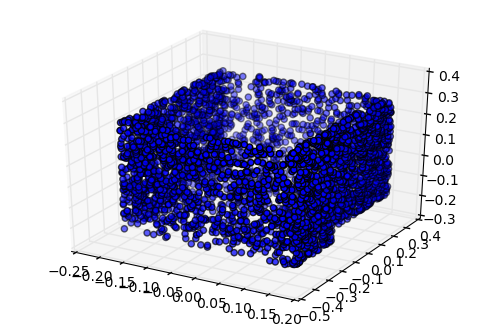

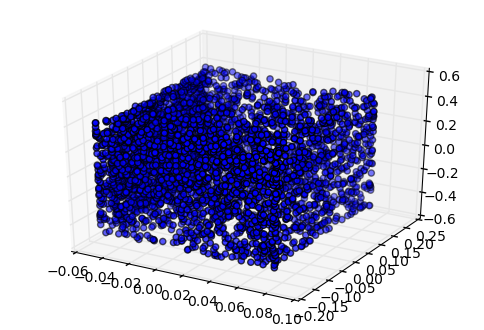

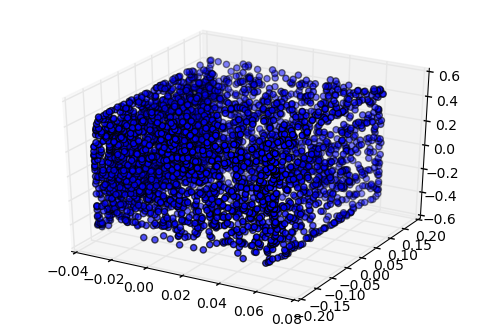

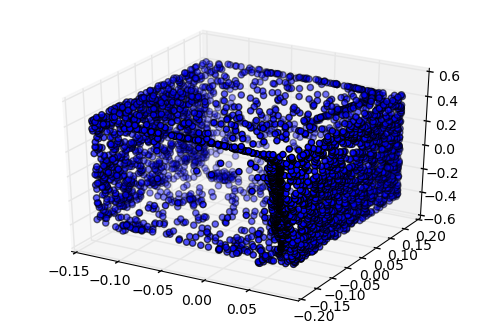

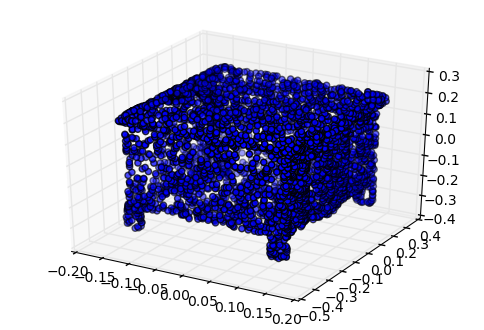

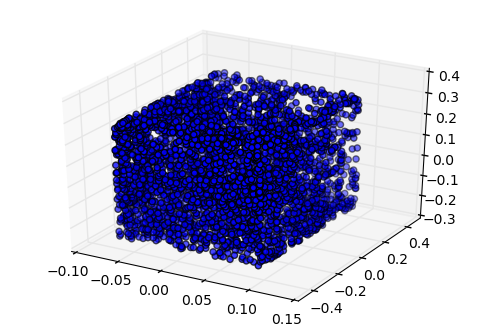

In [28]:
n_samples = 4096

for i in range(10):
    mesh_file = mesh_files[i]
    in_mesh = Mesh(file_name=mesh_file)
    in_mesh.swap_axes_of_vertices([0,2,1])
    model_name = mesh_file.split('/')[-2]
    in_mesh = cleaner.clean_mesh(in_mesh)
    in_mesh.center_in_unit_sphere()
    mesh_normals = Mesh.normals_of_triangles(in_mesh.vertices, in_mesh.triangles, normalize=True)
    
    ss_points, sample_face_idx = in_mesh.sample_faces(n_samples)
    
    
    pc = Point_Cloud(ss_points)
    pc = pc.center_in_unit_sphere()
    pc, lex_indices = pc.lex_sort()
    pc.plot()
    
    N = mesh_normals[sample_face_idx[lex_indices], :]
    points_and_normals = np.hstack((pc.points, N))    
    create_dir('/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/testing_normals/cabinet/')
    out_file = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/testing_normals/cabinet/' + model_name + '_' + str(n_samples) + '_normalized.txt'
    np.savetxt(out_file, points_and_normals)

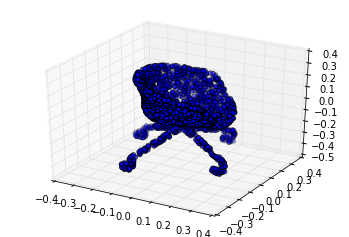

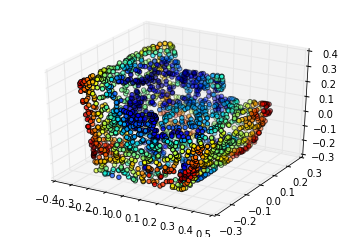

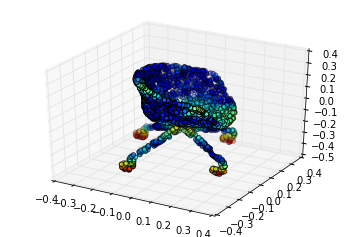

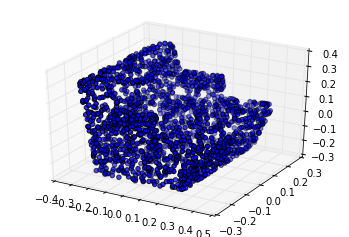

In [130]:
gt_pcloud = full_pclouds[0]
pred_pcloud = full_pclouds[6]

Point_Cloud(points=gt_pcloud).plot();
Point_Cloud(points=pred_pcloud).plot(c = dists1);

Point_Cloud(points=gt_pcloud).plot(c = dists2);
Point_Cloud(points=pred_pcloud).plot();


In [78]:


full_pclouds_path = osp.join(top_data_dir, 'ShapeNetPointClouds/from_manifold_meshes/2048/' + syn_id)
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path)

print '%d files containing complete point clouds were found.' % (len(full_pclouds), )

6778 files containing complete point clouds were found.


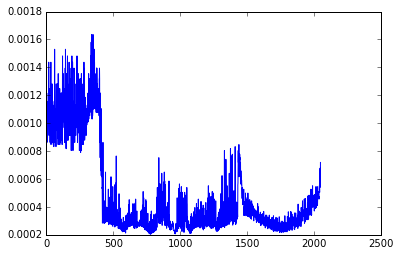

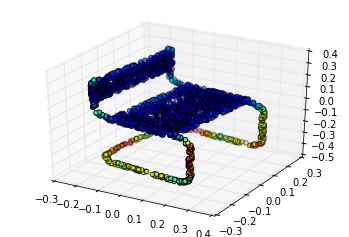

In [79]:
from sklearn.neighbors import NearestNeighbors

points = full_pclouds[10]

def density_weights(points, radius):
    nn = NearestNeighbors().fit(points)
    indices = nn.radius_neighbors(radius=radius, return_distance=False)
    density = np.array([i.size for i in indices], dtype=np.float128)
    return density

def inverse_normalize_weights(weights):
    w = weights
    inv_w = 1.0 / w[w != 0]
    w[w != 0] = inv_w
    w /= np.sum(w)
    return w.astype(np.float32)

w = inverse_normalize_weights(density_weights(points, radius = 0.1))

plt.plot(w)

pc = Point_Cloud(points=points)
pc.plot(c=w);


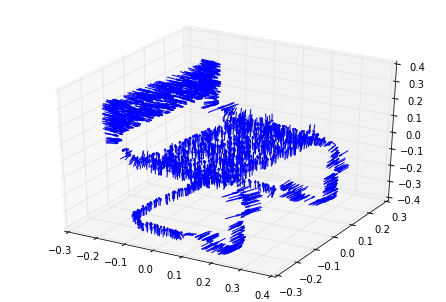

In [90]:



N = lsq_normal_estimation(pc, k=80)



import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
pts = pc.points

l2_norm = np.linalg.norm
row_norms = l2_norm(N, axis=1)
N = (N.T / row_norms).T
q = ax.quiver3D(pts[:,0], pts[:,1], pts[:,2], N[:,0], N[:,1], N[:,2], length=0.05)
  

6778 files containing complete point clouds were found.


In [122]:
full_pclouds_path = '/orions4-zfs/projects/lins2/Panos_Space/DATA/ShapeNetPointClouds/from_original_meshes/3000/no_segmentations/' + syn_id
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path)
full_pclouds_3, full_model_names_3, full_syn_ids_3 = pio.load_crude_point_clouds(file_names=full_file_names, n_threads=20)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )

7497 files containing complete point clouds were found.


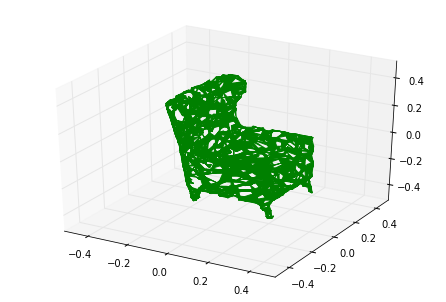

In [198]:
# shape_net_category_to_synth_id()
src = 100


trg = np.where(full_model_names[src] == full_model_names_2)[0][0]
# Point_Cloud(points= full_pclouds[src]).plot();
# Point_Cloud(points= full_pclouds_2[trg]).plot();

pts = full_pclouds_2[trg]

from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=6).fit(pts)
distances, indices = nn.kneighbors(pts)

# indices[:,1:].shape

tr = np.vstack((indices[:,0:3], indices[:,3:6]))
m = Mesh(vertices=pts, triangles=tr)
m.center_in_unit_sphere()

plot_mesh_2(m, in_u_sphere=True)

print 




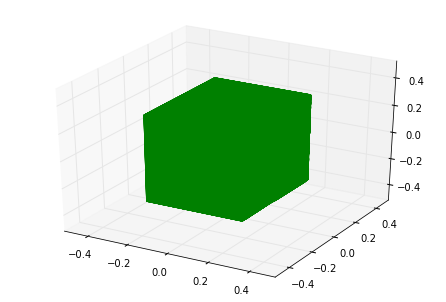

In [145]:
mesh_file = '/orions4-zfs/projects/lins2/Panos_Space/DATA/ShapeNetManifold/20000/04330267/177fedf455e50b4d352845ab138522d8//model.obj'
from geo_tool import Mesh
from tf_lab.autopredictors.exploration import plot_mesh_2

in_m = Mesh(file_name=mesh_file)
in_m.swap_axes_of_vertices([0,2,1])
in_m.center_in_unit_sphere()

plot_mesh_2(in_m, in_u_sphere=True)

In [149]:
in_m.triangles.shape

(78556, 3)

In [82]:
train_data_, val_data_, test_data_ = pio.train_validate_test_split([full_pclouds,                                                             
                                                            full_model_names],
                                                            train_perc=0.8,
                                                            validate_perc=0.1,
                                                            test_perc=0.1,
                                                            seed=seed)



test_data = merge_val_test_data(val_data_, test_data_)

10421

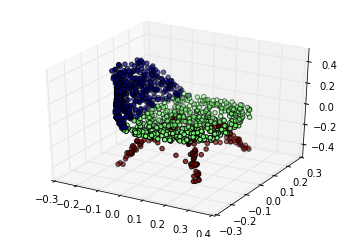

Point Cloud with 1024 points.


In [67]:

DATA_PATH = '/orions4-zfs/projects/lins2/Panos_Space/DATA/SN_with_part_annotation/03001627/expert_verified/points_label/'
model_id = '1015e71a0d21b127de03ab2a27ba7531.seg'
seg_file = osp.join(DATA_PATH, model_id)


DATA_PATH = '/orions4-zfs/projects/lins2/Panos_Space/DATA/SN_with_part_annotation/03001627/points/'
model_id = '1015e71a0d21b127de03ab2a27ba7531.pts'
pts_file = osp.join(DATA_PATH, model_id)





# bool_mask = np.logical_or(c==1, c==2)
# def apply_mask(self, bool_mask):
#     return Point_Cloud(self.points[bool_mask, :])
# apply_mask(pc, bool_mask).plot()

array([[ 0.26109004,  0.09401268, -0.02499332]], dtype=float32)

array([[-0.0246922 ,  0.10568816, -0.11596782]], dtype=float32)

array([False,  True,  True, ...,  True,  True, False], dtype=bool)

In [5]:
file_names = pio.load_filenames_of_input_data(DATA_PATH, verbose=VERBOSE)

all_pclouds, model_names, class_ids = pio.load_crude_point_clouds(file_names=file_names, n_threads=15, verbose=VERBOSE)

train_data_, val_data_, test_data_ = pio.train_validate_test_split(
                                                           [all_pclouds,                                                             
                                                            model_names],
                                                            train_perc=0.8,
                                                            validate_perc=0.1,
                                                            test_perc=0.1,
                                                            seed=seed)

trs = set(train_data_[1])
vas = set(val_data_[1])
tes = set(test_data_[1])

assert trs.isdisjoint(vas) and vas.isdisjoint(tes) and tes.isdisjoint(trs)

52103 files were found.
52103 pclouds were loaded. They belong in 50 shape-classes.


/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/tf_lab/point_clouds/in_out.py:64: UserWarning: Point clouds with the same model name were loaded.
  warnings.warn('Point clouds with the same model name were loaded.')


AssertionError: 

In [9]:
train_data = PointCloudDataSet(train_data_[0], labels=train_data_[1])
val_data = PointCloudDataSet(val_data_[0], labels=val_data_[1])
test_data = PointCloudDataSet(test_data_[0], labels=test_data_[1])

In [37]:
# Experimenting with Tensorboard - Visualizations
from tf_lab.fundamentals.inspect import hist_summary_of_trainable
writer = tf.summary.FileWriter('/Users/optas/Desktop/test', ae.graph)
# hist_summary_of_trainable(ae.graph)

In [ ]:
# If you 'merge' Erics pclouds with his segmentations then use.
def read_pcloud_with_segs(in_file):
    in_data = np.loadtxt(in_file)
    pts = in_data[:, [0, 1, 2]]
    seg = in_data[:, 3].astype(np.int32)
    return pts, seg